# 21M.387 Fundamentals of Music Processing
## Lab5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp
from fmplib.pyqueue import connect_to_queue

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['image.interpolation'] = 'nearest'

fmp.documentation_button()

## Exercise 1

For the matrix `m` below, create two vectors:
- the average values along the columns (to produce the average row vector)
- the average values along the rows (to produce the average column vector)

In [2]:
m = np.array(((8, 2, 7, 7), (6., 3, 5, 8), (1, 4, 9, 6)))
row_avgs = np.average(m, axis=1)
col_avgs = np.average(m, axis=0)
print(row_avgs)
print(col_avgs)
print(m)

[6.  5.5 5. ]
[5. 3. 7. 7.]
[[8. 2. 7. 7.]
 [6. 3. 5. 8.]
 [1. 4. 9. 6.]]


In [3]:
connect_to_queue()

## Exercise 2
In the following exercise, we will explore the auto-correlation tempogram using this piece of audio:

In [4]:
snd1 = fmp.load_wav("audio/queen_another_one.wav", 0, 30)
fs = 22050
ipd.Audio(snd1, rate = fs)

Generate $\Delta^s[n]$, the spectral novelty function of `snd` using:  
`fmp.spectral_novelty(x, win_len, hop_size, gamma)`

Use the parameters:
- $N=1024$ 
- $H=512$ 
- $\gamma=100$

Plot $\Delta^s[n]$

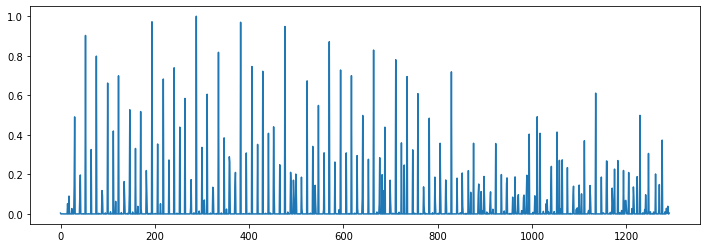

In [5]:
energy_signal = fmp.spectral_novelty(snd1, 1024, 512, 100)
plt.plot(energy_signal)

Now grab a small window of $\Delta^s[n]$ starting at $n=200$, with window length $L=256$. We'll call this signal $x[n]$.

Plot $x[n]$.

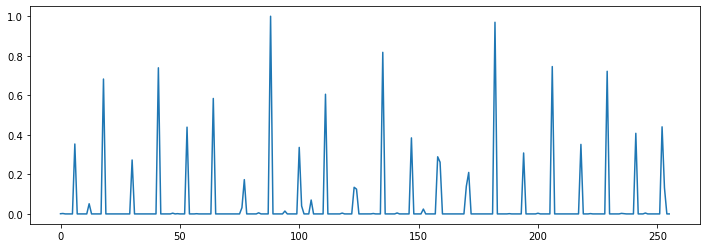

In [6]:
x = energy_signal[200:456]
plt.plot(x)

Create a function to compute the auto-correlation of a signal $x[n]$ with length $L$:
$$ R_{xx}[l] = \sum_{n=0}^{n=L-1} x[n] \cdot x[n-l] $$

You should assume that $x[n]$ is zero outside the window bounds $n \in [0,L-1]$.

Use a python `for` loop, where you loop over each lag value (from $0$ to $L-1$), computing $ R_{xx}[l]$ using the dot product.

- Find $R_{xx}$ for the windowed signal $x[n]$
- Plot the result

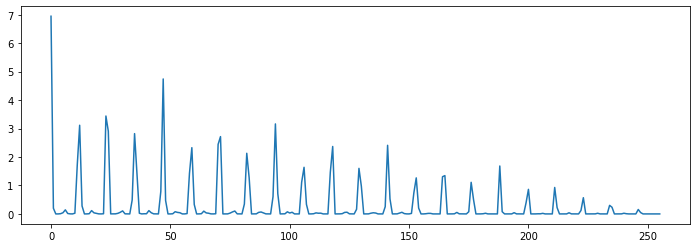

In [7]:
def auto_correlate(x):
    L = len(x)
    r = np.zeros(L)
    for l in range(L):
        #first vector is nonzero [0,L]
        #second is nonzero [l,L]
        r[l] = np.dot(x[l:L], x[0:L-l])
    return r

rxx = auto_correlate(x)
plt.plot(rxx)

In [8]:
connect_to_queue()

## Exercise 3
Create the same auto-correlation vector, but use the numpy function [`np.correlate`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html) to achieve the same result without using a `for` loop. Hint, use the optional argument `mode='full'`.

Plot this to show that both methods produce the same result.

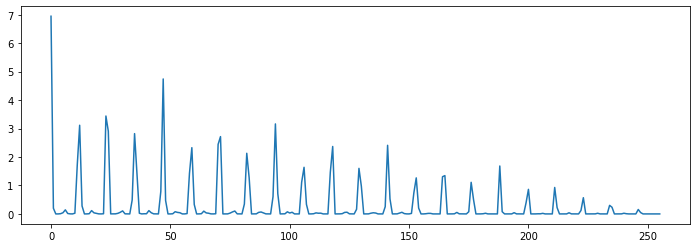

In [9]:
def test_ac(x) :
    L = len(x)
    dp = np.zeros(L)
    for l in range(L):
        a = x
        b = np.concatenate((np.zeros(l), x[0:L-l]))
        dp[l] = a.dot(b)
    return dp
rxx3 = test_ac(x)
plt.plot(rxx3)

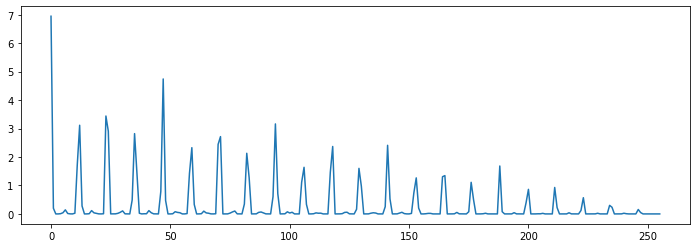

In [10]:
def np_auto_correlate(x):
    fullSignal = np.correlate(x,x, mode='full')
    return fullSignal[len(fullSignal)//2:]
rxx2 = np_auto_correlate(x)
plt.plot(rxx2)

In [11]:
connect_to_queue()

## Exercise 4

Write the function `lag_to_bpm(l, ff)` which takes a lag value `l` and feature frequency `ff`, and returns the BPM (beats per minute) associated with that lag value.

Given the parameters above
- What lag values ($l$) correspond to the first 4 peaks of the AC function (not including $l=0$)? Hint: you can use `fmp.find_peaks` with a threshold of $0.2$
- What tempos (BPM) values do these peaks correspond to?

In [12]:
def lag_to_bpm(l, ff):
    period = l * 1/ff
    bpm = 60 * 1/period
    return bpm
ff = 22050/512
best_lags = fmp.find_peaks(rxx, 0.2)[0:4]
bpms = [lag_to_bpm(i,ff) for i in best_lags]
print(best_lags)
print(bpms)

[12 23 35 47]
[215.33203125, 112.34714673913045, 73.828125, 54.97839095744681]


Here is some code for a metronome - it will play 10 clicks at the given BPM. Use this function to listen to the 4 candidate tempos of this song. Which of these tempo estimates are reasonable for this song?

In [13]:
def metronome(bpm) :
    print('tempo =', bpm)
    fs = 22050.
    beats = np.arange(10) * int(60. * fs  / bpm)
    click_snd = fmp.load_wav("audio/click.wav")
    clicks = fmp.make_clicks(beats, click_snd = click_snd)
    display(ipd.Audio(clicks, rate=fs))

In [14]:
for i in bpms:
    metronome(i)
#The second sounds right

tempo = 215.33203125


tempo = 112.34714673913045


tempo = 73.828125


tempo = 54.97839095744681


In [15]:
connect_to_queue()

## Exercise 5

We will now estimate the tempo values for the same window of audio using the Fourier method.

For the same windowed signal $x[n]$ (of length $L=N=256$), compute $X[k]$ the Fourier Transform (you can use the function `np.fft.rfft`). Remember also to use a Hann window.

Plot $\lvert X[k] \lvert$

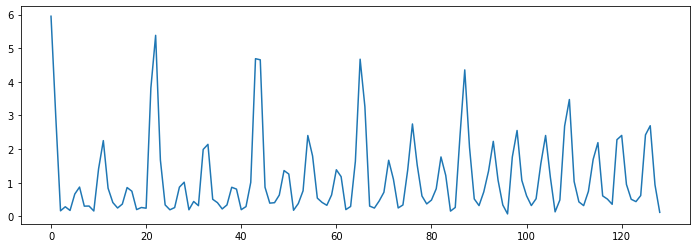

In [16]:
X = np.abs(np.fft.rfft(x*np.hanning(len(x))))
plt.plot(X)

Write the function `k_to_bpm(k, ...)` which returns the BPM corresponding to a given `k`. You will need to supply additional arguments to this function.

Given the Fourier Transform above:
- Find the frequency bins ($k$) corresponding to the first 4 prominent peaks (not including 0)? You can use a threshold value of $0.25$.
- What tempo (BPM) values correspond to these values of $k$?

In [17]:
def k_to_bpm(k, N, ff): # TODO, add additional args to this function as needed
    freq = ff * k/N
    bpm = freq*60
    return bpm
best_lags2 = fmp.find_peaks(X, 0.25)[0:4]
bpms2 = [k_to_bpm(i,256,ff) for i in best_lags2]
print(best_lags2)
print(bpms2)

[11 22 33 43]
[111.03057861328125, 222.0611572265625, 333.09173583984375, 434.02862548828125]


Now listen to these 4 tempos using the `metronome` function

In [18]:
for i in bpms2:
    metronome(i)
#The first sounds right

tempo = 111.03057861328125


tempo = 222.0611572265625


tempo = 333.09173583984375


tempo = 434.02862548828125


In [19]:
connect_to_queue()

## Exercise 6

What observations can you make about the tempo values predicted by each method and how they compare to each other?

In [20]:
#FFT gives higher tempos.
#Both sets of tempos are at almost regular intervals.

In [21]:
connect_to_queue()

## Exercise 7

Let's make the Fourier tempo prediction more accurate by zero-padding.

- Apply a Hann window to $x[n]$
- Zero-pad the result to be 8 times as long
- Take the FFT
- Plot the magnitude

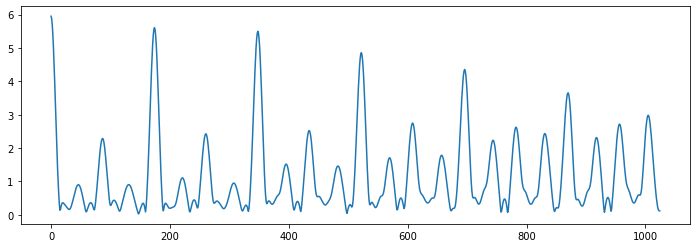

In [22]:
Xz = np.abs(np.fft.rfft(np.pad(x*np.hanning(len(x)), [(0, 7*len(x))], mode='constant')))
plt.plot(Xz)

As in Exercise 5, find the tempos predicted by the first four peaks. Then compare these to the original Fourier tempo estimates.

In [23]:
best_lags3 = fmp.find_peaks(Xz, 0.25)[0:4]
bpms3 = [k_to_bpm(i,256*8,ff) for i in best_lags3]
print(best_lags3)
print(bpms2)
print(bpms3)
for i in bpms3:
    metronome(i)
#The 109 seems good. Basically the same, just a bit more accurate hopefully.

[ 87 174 260 348]
[111.03057861328125, 222.0611572265625, 333.09173583984375, 434.02862548828125]
[109.76886749267578, 219.53773498535156, 328.0448913574219, 439.0754699707031]
tempo = 109.76886749267578


tempo = 219.53773498535156


tempo = 328.0448913574219


tempo = 439.0754699707031


In [24]:
connect_to_queue('checkoff')

## Exercise 8

If you have time left, load the beginning to Herbie Hancock's _Chameleon_ below and listen to the first 30 seconds or so.

$\Delta^s[n]$ is computed as above with $N=1024$, $H=512$, $\gamma = 100$ 

Find the candidate tempos of this song using the autocorrelation method and `fmp.find_peaks` threshold of $0.3$ on two different portions of the song:

- a window of length 11 seconds, starting at $t = 0$ seconds.
- a window of length 15 seconds, starting at $t = 15$ seconds.


Look at the first 3 candidate tempos of each portion. Can you explain what each peak "means"? In particular, the first section has an unusual 2nd tempo peak. Why is that?

It will help if you listen to these candidate tempos using the `metronome()` function.

[14 21 28 41]
[215.33203125, 112.34714673913045, 73.828125, 54.97839095744681]
tempo = 215.33203125


tempo = 112.34714673913045


tempo = 73.828125


tempo = 54.97839095744681


[14 27 41 46]
[215.33203125, 112.34714673913045, 73.828125, 54.97839095744681]
tempo = 215.33203125


tempo = 112.34714673913045


tempo = 73.828125


tempo = 54.97839095744681


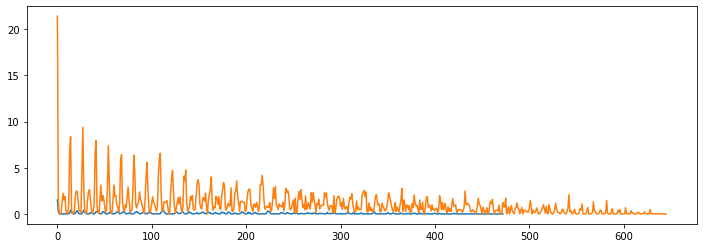

In [25]:
snd2 = fmp.load_wav('audio/hancock_chameleon.wav', 0, 30)
ipd.display(ipd.Audio(snd2, rate = fs))
win_len = 1024
hop_size = 512
gamma = 100
ff = fs / hop_size
nov2 = fmp.spectral_novelty(snd2, win_len, hop_size, gamma)
def do_stuff(x):
    rxx_c = auto_correlate(x)
    plt.plot(rxx_c)
    best_lags_c = fmp.find_peaks(rxx_c, 0.3)[0:4]
    bpms_c = [lag_to_bpm(i,ff) for i in best_lags]
    print(best_lags_c)
    print(bpms_c)
    for i in bpms_c:
        metronome(i)
        
do_stuff(nov2[0:int(11*ff)])
do_stuff(nov2[int(15*ff):int(30*ff)])